In [2]:
import numpy as np
import tqdm 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib import colors
import matplotlib as mpl 
import sys

sys.path.append('../my_funcs/')
from pipeline_main import pipeline, dist
from pipeline_main_nosink import pipeline_nosink, dist

import osyris
from osyris.plot.direction import get_direction

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)


In [3]:
data = pipeline(snap = 282, run = 'goodold13', sink_id = 13)
#data = pipeline_nosink(snap = 375, run = 'my_core_sink82', sink_pos = np.array([0.11083221, -0.44762421,  0.27573395]))
data.recalc_L(verbose = 1); 

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4165/4165 [00:20<00:00, 207.11it/s]


Converged mean angular momentum vector after 0 iteration(s)


In [4]:
pp = [p.position for p in data.sn.patches if p.level == 20]

In [5]:
np.median(pp, axis = 0)

array([ 0.1918869 , -0.43587494,  0.28832245])

In [16]:
view = 1000
selection_radius =  (np.sqrt(2 * (0.5*view)**2) * 2)/ data.au_length
pp = [p for p in data.sn.patches]
w= np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]; print(len(sorted_patches))

4165


In [28]:
nbors_len = []
for p in sorted_patches:
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    nbors_len.append(len(nbors))
    children = [ n for n in nbors if n.level == p.level]
    #if len(children) != 0: break
    print(len(children))
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]
nbors_len = np.array(nbors_len)

26
22
26
19
17
24
15
20
19
25
15
26
26
26
11
26
26
24
26
11
13
22
22
24
16
19
23
26
26
26
22
17
12
14
26
22
13
25
26
26
7
12
18
12
17
23
26
26
22
13
13
26
26
11
19
18
25
13
16
15
14
19
11
26
10
8
26
25
21
19
12
21
17
17
11
11
14
23
21
26
12
16
9
11
14
18
13
8
15
18
25
26
14
16
26
26
26
26
26
23
15
25
21
25
21
25
26
26
14
11
15
17
26
25
17
14
19
26
24
23
13
17
12
17
26
24
14
18
19
11
18
16
21
26
22
14
15
17
25
26
24
12
17
12
25
22
25
24
17
17
12
19
12
13
26
13
14
24
17
26
26
16
13
13
17
26
17
25
16
26
13
23
16
14
17
26
23
18
20
25
10
26
14
17
23
23
26
24
19
13
20
26
13
16
25
14
16
20
26
16
18
25
22
13
13
12
17
17
17
17
17
26
26
19
13
26
21
21
26
25
26
17
19
19
26
21
18
26
25
17
17
17
25
18
25
9
18
21
23
26
23
11
26
9
24
19
17
13
17
20
26
26
26
26
11
12
14
18
14
21
23
26
17
17
26
10
11
26
15
20
26
20
26
26
25
26
20
11
12
26
20
26
26
25
26
24
26
23
13
26
17
26
26
23
25
26
14
10
26
26
21
25
17
16
22
12
26
26
14
10
22
18
15
16
21
22
17
24
26
12
17
26
17
12
15
17
20
26
26
17
13
15
25
22
26
2

In [26]:
children

### Åke on p.extent:
The same (for each axis) as the optional argument extent=p.extent[axis] in plt.imshow (edited) 
So, [ymin, ymax, zmin, zmax] for axis=0

In [8]:
data.calc_disksize(plot = False)

Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4165/4165 [00:00<00:00, 15856.78it/s]

Disk size: 79.3 au


In [9]:
ivs = 'd'
patch_values = []
patch_values2 = []
patch_cartcoor = []
patch_ds = []
for p in tqdm.tqdm(sorted_patches):
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]
    if len(leafs) == 8: continue
    to_extract = np.ones(p.n, dtype=bool)
    for lp in leafs:
        
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
        to_extract *= covered_bool

    new_xyz = p.rel_xyz[:,to_extract].T
    new_Vxyz = p.vrel[:,to_extract].T
    new_value = p.var(ivs)[to_extract].T
    
    patch_ds.extend(p.ds[0] * np.ones(len(new_value)))
    patch_cartcoor.extend(new_xyz.tolist())
    patch_values.extend(new_value.tolist())
    patch_values2.extend(new_Vxyz.tolist())

        
patch_ds = np.asarray(patch_ds)
patch_cartcoor = np.asarray(patch_cartcoor)
patch_values = np.asarray(patch_values)
patch_values2 = np.asarray(patch_values2) * data.cms_velocity

  0%|          | 0/1897 [00:00<?, ?it/s]

100%|██████████| 1897/1897 [00:23<00:00, 80.37it/s] 


In [10]:
patch_values2.shape

(6802944, 3)

In [11]:
ds = osyris.Dataset(nout = None)
# overwrite units
ds.meta['unit_l'] = data.sn.scaling.l
ds.meta['unit_t'] = data.sn.scaling.t
ds.meta['unit_d'] = data.sn.scaling.d
ds.set_units()
ds.meta["ndim"] = 3

In [12]:

ds['amr'] = osyris.Datagroup()
ds['amr']['dx'] = osyris.Array(patch_ds*data.sn.scaling.l, unit='cm')
ds['amr']['position'] = osyris.Vector(x=patch_cartcoor[:,0]*data.sn.scaling.l, y=patch_cartcoor[:,1]*data.sn.scaling.l, z=patch_cartcoor[:,2]*data.sn.scaling.l, unit='cm')
ds['hydro'] = osyris.Datagroup()
ds['hydro']['density'] = osyris.Array(patch_values*data.sn.scaling.d, unit='g/cm^3')
ds['hydro']['velocity'] = osyris.Vector(x=patch_values2[:,0], y=patch_values2[:,1], z=patch_values2[:,2], unit='cm/s')

In [13]:
data.L

array([ 0.86986704, -0.37806712, -0.31685421])

In [14]:
L=osyris.Vector(x=data.L[0],y=data.L[1],z=data.L[2])
print(L)

'' Value: 0.870, -0.378, -0.317 [] (), {x,y,z}


In [15]:
view

1000

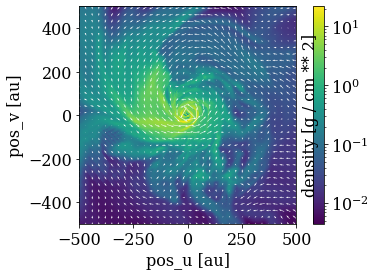

In [16]:
view_au = view * osyris.units('au')
res = 400
center = osyris.Vector(x=0,y=0,z=0,unit='au')
ret = osyris.map({"data": ds['hydro']['density'], "norm": "log"}, 
                 {"data": ds['hydro']['velocity'], "mode": "vec"},
                 dx=view_au, dz = 0.1 * view_au, origin=center, resolution=res, direction=L, plot=True)

ret

In [17]:
plot_height = 0.1 * 200 * data.sn.cgs.au
plot_height

299200000000000.0

In [18]:
np.sum(data.L[None, None, :] * ret.layers[1]['data'], axis = -1).shape

(400, 400)

In [19]:
dz = 0.1 * view
plot_height = dz / osyris.units('au') * data.sn.cgs.au

In [20]:
plot_height

1496000000000000.0 <Unit('1 / astronomical_unit')>

In [21]:
projected_vel = ret.layers[1]['data'] /plot_height # - (np.sum(data.L[None, None, :] * ret.layers[1]['data'], axis = -1)[...,None] * data.L[None, None, :])

/groups/astro/kxm508/.local/lib/python3.8/site-packages/numpy/ma/core.py:711: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(a, copy=False, subok=subok)


# NOW THIS PLOT IS CORRECT!!!!

In [22]:
projected_vel.shape

(400, 400, 3)

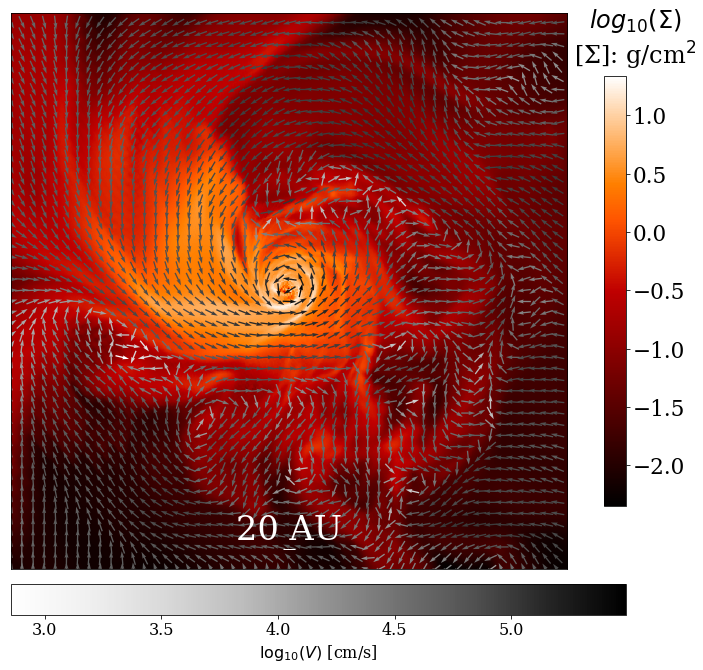

In [23]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm


X, Y = np.linspace(-500,500,res), np.linspace(-500,500,res),
xx,yy = np.meshgrid(X, Y)
density = 1.5
skips = np.around(np.array(ret.layers[1]['data'].shape) * 4.0 / 128.0 / density).astype(int)
skip = (slice(None, None, skips[0]), slice(None, None, skips[1]))

arrow_length = np.sqrt(projected_vel[...,0]**2 + projected_vel[...,1]**2)[skip]

fig, axs = plt.subplots(figsize = (10,10))
cs = axs.imshow(np.log10(ret.layers[0]['data']),  cmap = 'gist_heat', extent = (-500, 500, -500, 500), origin ='lower')
quiver = axs.quiver(xx[skip], yy[skip], projected_vel[...,0][skip] / arrow_length, projected_vel[...,1][skip] / arrow_length, np.log10(arrow_length), pivot = 'mid', scale = 40,
                    cmap=mpl.cm.Greys)
cbar_vel = fig.colorbar(quiver, pad = 0.005, location = 'bottom')
cbar_vel.set_label('$\log_{10}(V)$ [cm/s]')

cbar = fig.colorbar(cs, ax = axs, fraction = 0.035, pad = 0.06);
cbar.ax.xaxis.set_label_coords(-10, -10)
axs.set_xticks([]); axs.set_yticks([])
cbar.set_label('$log_{10}(Σ)$\n[Σ]: g/cm$^2$', labelpad = -50, y = 1.16, rotation = 0, fontsize = 20*1.2)
cbar.ax.tick_params(labelsize=18*1.20)
scalebar = AnchoredSizeBar(axs.transData, 20, '20 AU', 'lower center', 
                           pad=0.5,
                           color='white',
                           frameon=False,
                           fontproperties = fm.FontProperties(size=28*1.2), 
                           size_vertical=1,
                           label_top=True)

axs.add_artist(scalebar)
#axs.set_title(f'Log10 Surface density, ZY-plane, Time = {data.time:4.0f} yr', fontsize = 20)
plt.tight_layout()

In [28]:
skips

array([3, 3, 0])

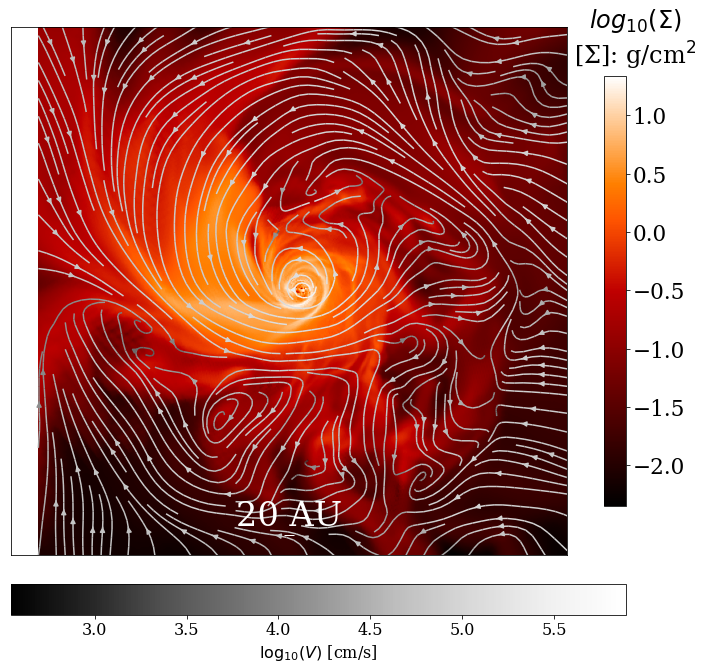

In [45]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm


X, Y = np.linspace(-500,500,res), np.linspace(-500,500,res),
xx,yy = np.meshgrid(X, Y)
density = 0.1
skips = np.around(np.array(ret.layers[1]['data'].shape) * 4.0 / 128.0 / density).astype(int)
skip = (slice(None, None, skips[0]), slice(None, None, skips[1]))

arrow_length = np.sqrt(projected_vel[...,0]**2 + projected_vel[...,1]**2)

fig, axs = plt.subplots(figsize = (10,10))
cs = axs.imshow(np.log10(ret.layers[0]['data']),  cmap = 'gist_heat', extent = (-500, 500, -500, 500), origin ='lower')



strm  = axs.streamplot(xx, yy, projected_vel[...,0] , projected_vel[...,1], color = np.log10(arrow_length), cmap=mpl.cm.Greys_r, density = 2)

cbar_vel = fig.colorbar(strm.lines, pad = 0.005, location = 'bottom')
cbar_vel.set_label('$\log_{10}(V)$ [cm/s]')

cbar = fig.colorbar(cs, ax = axs, fraction = 0.035, pad = 0.06);
cbar.ax.xaxis.set_label_coords(-10, -10)
axs.set_xticks([]); axs.set_yticks([])
cbar.set_label('$log_{10}(Σ)$\n[Σ]: g/cm$^2$', labelpad = -50, y = 1.16, rotation = 0, fontsize = 20*1.2)
cbar.ax.tick_params(labelsize=18*1.20)
scalebar = AnchoredSizeBar(axs.transData, 20, '20 AU', 'lower center', 
                           pad=0.5,
                           color='white',
                           frameon=False,
                           fontproperties = fm.FontProperties(size=28*1.2), 
                           size_vertical=1,
                           label_top=True)

axs.add_artist(scalebar)
#axs.set_title(f'Log10 Surface density, ZY-plane, Time = {data.time:4.0f} yr', fontsize = 20)
plt.tight_layout()